# 1.1 Activation Maximization

A deep neural network classifier mapping a set of data points or images $x$ to a set of classes $(\omega_c)_c$ models the conditional probability distribution $p(\omega_c | x)$. Therefore, a prototype $x^{*}$ can be found by optimizing the following objective:

$$\max_x \log p(\omega_c | x) - \lambda \lVert x\rVert^2$$

This can be achieved by first training a deep neural network and then performing gradient ascent on prepared prototype images. The rightmost term of the objective function ($\lambda \lVert x\rVert^2$) is an $l_2$-norm regularizer that prevents prototype images from deviating largely from the origin. Activation maximization is crude compared to other interpretation techniques and produces unnatural prototype images.

## Tensorflow Implementation

### 1. Import Dependencies

I created a separate module for DNN models. You can check out models.py for more network details.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models import MNIST_DNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/DNN/'
ckptdir = logdir + 'model'

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a regular DNN classifier is initialized and necessary nodes for model training is added onto the graph.

In [2]:
# Hyper parameters
training_epochs = 15
batch_size = 100

# Initialize neural network
DNN = MNIST_DNN('DNN')

# Setup training process
training = tf.placeholder_with_default(True, shape=[], name='training')
lmda = tf.placeholder_with_default(0.01, shape=[], name='lambda')
X = tf.placeholder(tf.float32, [None, 784], name='X')
Y = tf.placeholder(tf.float32, [None, 10], name='Y')

tf.add_to_collection('placeholders', training)
tf.add_to_collection('placeholders', lmda)

logits = DNN(X, training)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
cost_summary = tf.summary.scalar('Cost', cost)

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Back to building original graph
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuray_summary = tf.summary.scalar('Accuracy', accuracy)

summary = tf.summary.merge_all()

### 3. Building Subgraph for Generating Prototypes

Before training the network, a subgraph for generating prototypes is added onto the graph. This subgraph will be used after training the model.

In [3]:
X_prototype = tf.get_variable('X_prototype', shape=[10, 784], initializer=tf.constant_initializer(0.))
Y_prototype = tf.one_hot(tf.cast(tf.lin_space(0., 9., 10), tf.int32), depth=10)

logits_prototype = DNN(X_prototype, training, reuse=True)

# Objective function definition
cost_prototype = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_prototype, labels=Y_prototype)) \
                 + lmda * tf.nn.l2_loss(X_prototype)

optimizer_prototype = tf.train.AdamOptimizer().minimize(cost_prototype, var_list=[X_prototype])

# Add the subgraph nodes to a collection so that they can be used after training of the network
tf.add_to_collection('prototype', X_prototype)
tf.add_to_collection('prototype', Y_prototype)
tf.add_to_collection('prototype', logits_prototype)
tf.add_to_collection('prototype', cost_prototype)
tf.add_to_collection('prototype', optimizer_prototype)

Here's the general structure of the computation graph visualized using tensorboard.

![title](./assets/1_Activation_Maximization/graph.png)

### 4. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard.

In [4]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, training:False}))

sess.close()

Epoch: 0001 cost = 1.181238449 accuracy = 0.590654545
Epoch: 0002 cost = 0.477431769 accuracy = 0.869527272
Epoch: 0003 cost = 0.385082671 accuracy = 0.896745455
Epoch: 0004 cost = 0.346580063 accuracy = 0.910200001
Epoch: 0005 cost = 0.324798550 accuracy = 0.916309093
Epoch: 0006 cost = 0.302059339 accuracy = 0.922272729
Epoch: 0007 cost = 0.291761514 accuracy = 0.926036366
Epoch: 0008 cost = 0.273012672 accuracy = 0.930854548
Epoch: 0009 cost = 0.271883968 accuracy = 0.930490910
Epoch: 0010 cost = 0.263011809 accuracy = 0.934454548
Epoch: 0011 cost = 0.256506125 accuracy = 0.934672730
Epoch: 0012 cost = 0.253230740 accuracy = 0.937963637
Epoch: 0013 cost = 0.251060937 accuracy = 0.937727275
Epoch: 0014 cost = 0.243583188 accuracy = 0.940945456
Epoch: 0015 cost = 0.237729850 accuracy = 0.941090912
Accuracy: 0.9677


### 5. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the tf.get_collection() function (remeber prototype subgraph nodes were added onto the 'prototype' collection at step 3).

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

# Get necessary placeholders
training = tf.get_collection('placeholders')[0]
lmda = tf.get_collection('placeholders')[1]

# Get prototype nodes
prototype = tf.get_collection('prototype')
X_prototype = prototype[0]
cost_prototype = prototype[3]
optimizer_prototype = prototype[4]

INFO:tensorflow:Restoring parameters from ./tf_logs/DNN/model


### 6. Generating Prototype Images

Here, gradient ascent is performed upon prototype images so that they maximize $\log p(\omega_c | x) - \lambda \lVert x\rVert^2$. I used 0.1 for lambda (lmda), but fine tuning may produce better prototype images.

In [6]:
for epoch in range(5000):
    _, c = sess.run([optimizer_prototype, cost_prototype], feed_dict={training: False, lmda: 0.1})
    
    if epoch % 500 == 0:
        print('Epoch: {:05d} Cost = {:.9f}'.format(epoch, c))
    
X_prototypes = sess.run(X_prototype)

sess.close()

Epoch: 00000 Cost = 3.250527143
Epoch: 00500 Cost = 0.072722316
Epoch: 01000 Cost = 0.072382003
Epoch: 01500 Cost = 0.072376907
Epoch: 02000 Cost = 0.072412491
Epoch: 02500 Cost = 0.072396368
Epoch: 03000 Cost = 0.072405562
Epoch: 03500 Cost = 0.072427377
Epoch: 04000 Cost = 0.072450995
Epoch: 04500 Cost = 0.072446711


### 7. Displaying Images

They are rather blurry and nearly impossible to see for digits 5 and 8. Feel free to play around with cmap and interpolation settings.

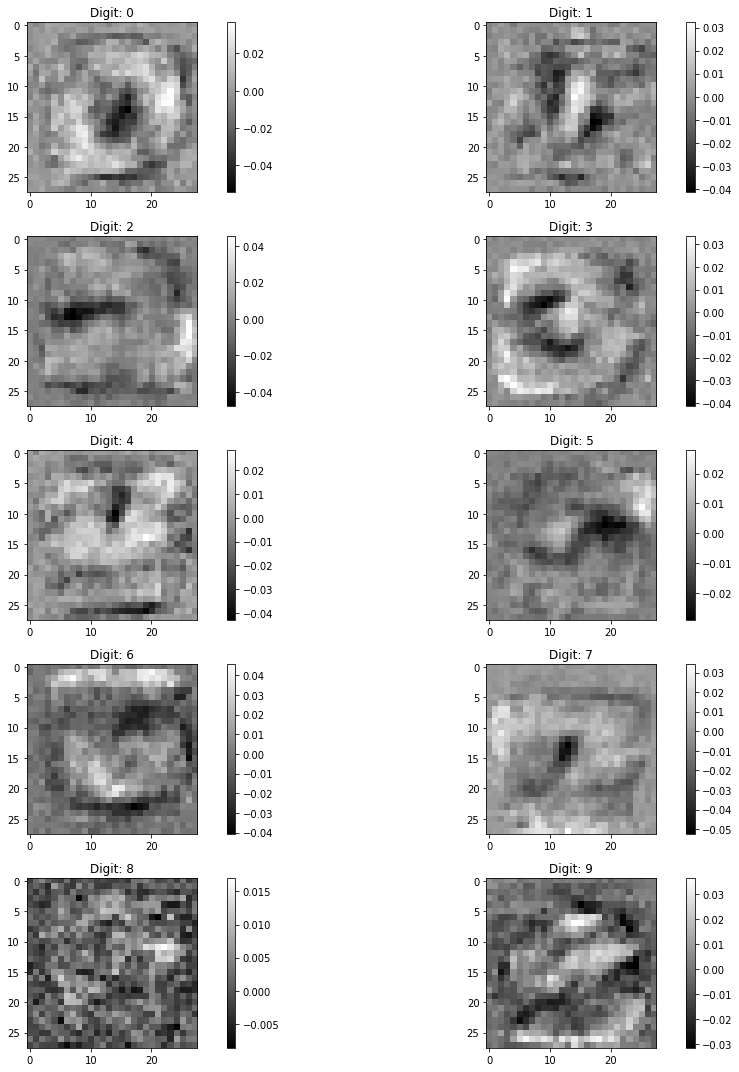

In [7]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(X_prototypes[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(X_prototypes[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()